<a href="https://colab.research.google.com/github/ahmedmaged0/AD_Networks/blob/main/AD_in_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
import networkx as nx
import random
import numpy as np


def create_graph(anomaly=False):

    G = nx.Graph()

    # Add nodes
    G.add_nodes_from(range(15))

    # Add edges
    for i in range(14):
        G.add_edge(i, i + 1)

    if anomaly:
        specific_node = 10
        for _ in range(10):
            G.add_edge(specific_node, random.choice(list(set(range(15)) - {specific_node})))

    return G


graphs = []

for _ in range(30):
    graphs.append(create_graph(anomaly=False))

for _ in range(30):
    graphs.append(create_graph(anomaly=True))


In [17]:
import networkx as nx
import random

#Barabási-Albert graph
def create_graph(n=50, m=2, anomaly=False, specific_node=15, extra_edges=30):
    G = nx.barabasi_albert_graph(n, m)

    if anomaly:
        for _ in range(extra_edges):
            potential_nodes = set(range(n)) - {specific_node} - set(G.neighbors(specific_node))
            if potential_nodes:
                G.add_edge(specific_node, random.choice(list(potential_nodes)))

    return G

graphs = []

for _ in range(40):
    graphs.append(create_graph(anomaly=False))

for _ in range(30):
    graphs.append(create_graph(anomaly=True))



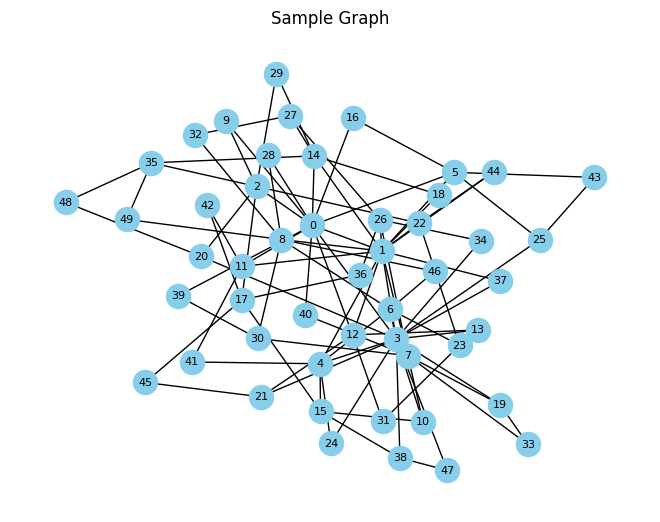

In [19]:
import matplotlib.pyplot as plt

graph_to_plot = graphs[0]

pos = nx.spring_layout(graph_to_plot, k=0.15, iterations=20)

nx.draw(graph_to_plot, pos, with_labels=True, node_size=300, node_color="skyblue", font_size=8, font_color="black")

edge_labels = nx.get_edge_attributes(graph_to_plot, 'weight')  # Replace 'weight' with relevant attribute
nx.draw_networkx_edge_labels(graph_to_plot, pos, edge_labels=edge_labels)

plt.title("Sample Graph")
plt.show()

In [18]:
from sklearn.model_selection import train_test_split

test_size = 0.5

train_data, test_data = train_test_split(graphs, test_size=test_size, shuffle=False)

In [4]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 4.6 MB/s eta 0:00:00


In [19]:
import torch
from torch_geometric.data import DataLoader, Dataset
from torch_geometric.nn import VGAE, GCNConv
from torch_geometric.utils import from_networkx

class GraphDataset(Dataset):
    def __init__(self, graph_list):
        super(GraphDataset, self).__init__()
        self.graph_list = graph_list

    def len(self):
        return len(self.graph_list)

    def get(self, idx):
        G = self.graph_list[idx]
        data = from_networkx(G)
        data.x = torch.eye(data.num_nodes)  # Initialize node features to identity matrix
        return data


dataset = GraphDataset(train_data)

batch_size = 1
loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

# VGAE Encoder
class Encoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Encoder, self).__init__()
        self.conv1 = GCNConv(in_channels, 2 * out_channels, cached=True)
        self.conv_mu = GCNConv(2 * out_channels, out_channels, cached=True)
        self.conv_logstd = GCNConv(2 * out_channels, out_channels, cached=True)

    def forward(self, x, edge_index):
        x = torch.relu(self.conv1(x, edge_index))
        return self.conv_mu(x, edge_index), self.conv_logstd(x, edge_index)

in_channels = dataset.num_node_features
out_channels = 15
encoder = Encoder(in_channels, out_channels)
model = VGAE(encoder)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

loss_values = []
for epoch in range(70):
    model.train()
    total_loss = 0.0
    for da in loader:
        optimizer.zero_grad()
        z = model.encode(da.x, da.edge_index)
        loss = model.recon_loss(z, da.edge_index) + (1 / da.num_nodes) * model.kl_loss()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    average_loss = total_loss / len(loader)
    loss_values.append(average_loss)
    print(f"Epoch {epoch+1}/{70}, Loss: {average_loss:.4f}")

Epoch 1/70, Loss: 3.1294
Epoch 2/70, Loss: 2.6530
Epoch 3/70, Loss: 2.1428
Epoch 4/70, Loss: 1.8374
Epoch 5/70, Loss: 1.6820
Epoch 6/70, Loss: 1.6450
Epoch 7/70, Loss: 1.6302
Epoch 8/70, Loss: 1.6192
Epoch 9/70, Loss: 1.6210
Epoch 10/70, Loss: 1.6274
Epoch 11/70, Loss: 1.6126
Epoch 12/70, Loss: 1.6236
Epoch 13/70, Loss: 1.6169
Epoch 14/70, Loss: 1.6154
Epoch 15/70, Loss: 1.6194
Epoch 16/70, Loss: 1.6108
Epoch 17/70, Loss: 1.6123
Epoch 18/70, Loss: 1.6075
Epoch 19/70, Loss: 1.5942
Epoch 20/70, Loss: 1.6029
Epoch 21/70, Loss: 1.5954
Epoch 22/70, Loss: 1.6017
Epoch 23/70, Loss: 1.5952
Epoch 24/70, Loss: 1.6015
Epoch 25/70, Loss: 1.6044
Epoch 26/70, Loss: 1.6000
Epoch 27/70, Loss: 1.5942
Epoch 28/70, Loss: 1.5813
Epoch 29/70, Loss: 1.5946
Epoch 30/70, Loss: 1.5971
Epoch 31/70, Loss: 1.5872
Epoch 32/70, Loss: 1.5803
Epoch 33/70, Loss: 1.5939
Epoch 34/70, Loss: 1.5855
Epoch 35/70, Loss: 1.5839
Epoch 36/70, Loss: 1.5929
Epoch 37/70, Loss: 1.5837
Epoch 38/70, Loss: 1.5780
Epoch 39/70, Loss: 1.

In [20]:
all_dataset = GraphDataset(graphs)

all_loader = DataLoader(all_dataset, batch_size=1, shuffle=False)
jaccard_scores = []

for i, pyg_data in enumerate(all_loader):

    model.eval()
    z = model.encode(pyg_data.x, pyg_data.edge_index)

    # Initialize a zero matrix of size equal to the number of nodes in pyg_data
    reconstructed_matrix = torch.zeros(pyg_data.num_nodes, pyg_data.num_nodes)

    # Get edge probabilities from VGAE decoder
    edge_probs = torch.sigmoid(model.decoder.forward(z, pyg_data.edge_index, sigmoid=False)).detach()

    # Map these probabilities to their corresponding edges in the matrix
    for idx, (node1, node2) in enumerate(zip(pyg_data.edge_index[0], pyg_data.edge_index[1])):
        reconstructed_matrix[node1][node2] = edge_probs[idx]
        if not pyg_data.is_directed():
            reconstructed_matrix[node2][node1] = edge_probs[idx]

    # Convert the graph to its adjacency matrix
    Actual_adj = torch.Tensor(nx.adjacency_matrix(graphs[i]).todense())


    # Compute the Jaccard Similarity
    intersection = torch.sum(Actual_adj * reconstructed_matrix)
    union = torch.sum((Actual_adj + reconstructed_matrix) >= 1)
    jaccard_similarity = intersection / union
    jaccard_scores.append(jaccard_similarity.item())
    print(f"Graph {i}: JS score:", jaccard_similarity.item())

    # Compute the reconstruction error for each node
    errors = torch.sum(torch.abs(Actual_adj - reconstructed_matrix), dim=1)
    anomaly_score, anomalous_nodes = torch.topk(errors, 10)

    print(f"Graph {i}: Anomalous Nodes:", anomalous_nodes.tolist())
    print(f"Graph {i}: Anomaly Scores:", anomaly_score.tolist())


Graph 0: JS score: 0.599416196346283
Graph 0: Anomalous Nodes: [3, 1, 14, 17, 0, 4, 2, 6, 26, 10]
Graph 0: Anomaly Scores: [4.655513763427734, 3.960536003112793, 3.8303933143615723, 3.1811234951019287, 3.0367791652679443, 2.721587657928467, 2.5919904708862305, 2.4330668449401855, 2.423339605331421, 2.2490460872650146]
Graph 1: JS score: 0.5853641629219055
Graph 1: Anomalous Nodes: [7, 1, 0, 6, 11, 10, 19, 3, 15, 30]
Graph 1: Anomaly Scores: [4.527209281921387, 4.228553295135498, 4.153468132019043, 3.291682004928589, 3.083465099334717, 2.953169345855713, 2.9297735691070557, 2.7464609146118164, 2.2311787605285645, 2.015263080596924]
Graph 2: JS score: 0.5910702347755432
Graph 2: Anomalous Nodes: [3, 18, 0, 35, 14, 5, 10, 7, 11, 9]
Graph 2: Anomaly Scores: [5.486993312835693, 3.751642942428589, 3.697249174118042, 3.3114380836486816, 3.1782383918762207, 2.4885964393615723, 2.3250656127929688, 2.307616710662842, 2.1540300846099854, 1.8953280448913574]
Graph 3: JS score: 0.600107729434967
Gr

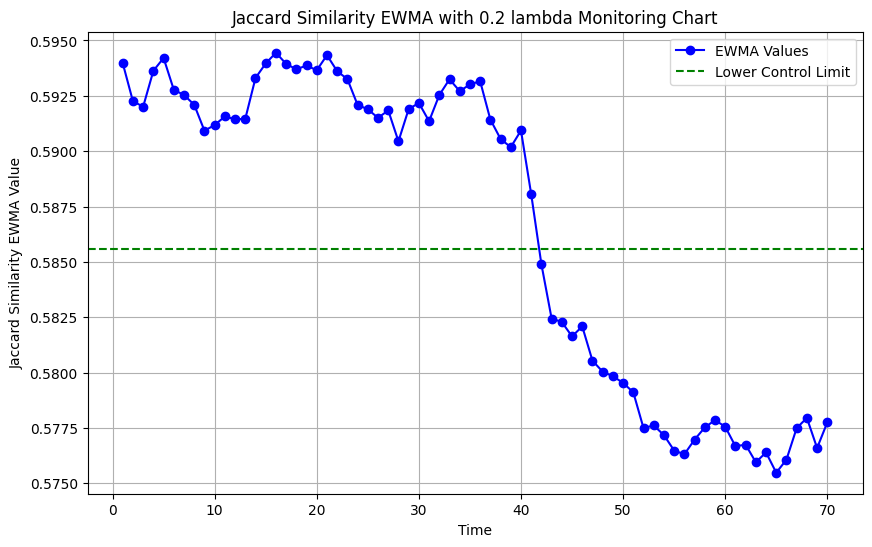

In [21]:
import numpy as np
import matplotlib.pyplot as plt

EWMAt_1 = torch.mean(torch.tensor(jaccard_scores[0:30]))  # Initial EWMA value is the mean of JS scores
alpha = 0.2
ewma_values = []

for value in jaccard_scores:
    EWMAt = alpha * value + (1 - alpha) * EWMAt_1
    ewma_values.append(EWMAt)
    EWMAt_1 = EWMAt

ewma_std = np.std(ewma_values)

upper_control_limit = np.mean(ewma_values[0:30]) + 1 * ewma_std
lower_control_limit = np.mean(ewma_values[0:30]) - 1 * ewma_std

time_axis = range(1, len(jaccard_scores) + 1)

plt.figure(figsize=(10, 6))
plt.plot(time_axis, ewma_values, label='EWMA Values', marker='o', linestyle='-', color='blue')
#plt.axhline(upper_control_limit, color='red', linestyle='--', label='Upper Control Limit')
plt.axhline(lower_control_limit, color='green', linestyle='--', label='Lower Control Limit')
plt.xlabel('Time')
plt.ylabel('Jaccard Similarity EWMA Value')
plt.title(f'Jaccard Similarity EWMA with {alpha} lambda Monitoring Chart')
plt.legend()
plt.grid(True)
plt.show()

(array([3., 4., 2., 5., 7., 7., 2., 6., 1., 2.]),
 array([0.58450449, 0.58612236, 0.58774023, 0.5893581 , 0.59097598,
        0.59259385, 0.59421172, 0.59582959, 0.59744747, 0.59906534,
        0.60068321]),
 <BarContainer object of 10 artists>)

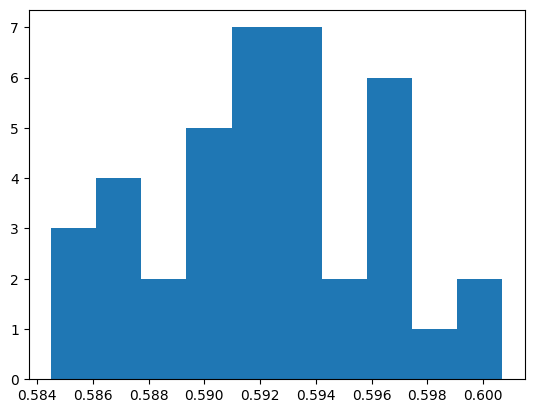

In [23]:
plt.hist(jaccard_scores[1:40])